武漢の数理モデル作成とパラメータフィッティング
===

このコードは
1. 武漢のSIRモデル及び，SIERモデルを用いた数理モデル化
1. パラメータフィッティング
1. 被害の予測
を行う

In [361]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings('ignore')

## 武漢のデータのimport

In [362]:
target_place = 'Hubei'

In [363]:
# Nの導出
df_p = pd.read_csv('data/2017_China_data.csv')
N = df_p[df_p['Province/State'] == target_place].population.values[0]

In [364]:
# Preprocessing
df_disease = pd.read_csv('data/2019_nCoV_data.csv')
df_disease.Country[df_disease.Country == 'China'] = 'Mainland China'
# 台湾の国名をTiwanに統一
df_disease.Country[df_disease['Province/State']=='Taiwan'] = 'Taiwan'
# 時系列データの抜き出し


In [365]:
df_Hubei = df_disease[df_disease['Province/State']== target_place]
df_Hubei.Date = pd.to_datetime(df_Hubei.Date)
df_Hubei.Date = df_Hubei.Date.dt.date
# 日付の記述が間違っているので修正
df_Hubei.Date[df_Hubei.Date== datetime.date(2020,1,2)]= datetime.date(2020,2,1)
# 開始からの日付の追加
df_Hubei['Days'] = df_Hubei.Date - df_Hubei.Date.values[0]
df_Hubei['Days'] = df_Hubei['Days'].dt.days
df_Hubei

,Sno,Date,Province/State,Country,Last Update,Confirmed,Deaths,Recovered,Days
13,14,2020-01-22,Hubei,Mainland China,1/22/2020 12:00,444.0,0.0,0.0,0
51,52,2020-01-23,Hubei,Mainland China,1/23/20 12:00 PM,444.0,17.0,28.0,1
83,84,2020-01-24,Hubei,Mainland China,1/24/2020 12:00 PM,549.0,24.0,31.0,2
124,125,2020-01-25,Hubei,Mainland China,1/25/2020 10:00 PM,1052.0,52.0,42.0,3
168,169,2020-01-26,Hubei,Mainland China,1/26/2020 23:00,1423.0,76.0,44.0,4
215,216,2020-01-27,Hubei,Mainland China,1/27/2020 20:30,2714.0,100.0,47.0,5
267,268,2020-01-28,Hubei,Mainland China,1/28/2020 23:00,3554.0,125.0,80.0,6
319,320,2020-01-29,Hubei,Mainland China,1/29/2020 21:00,4586.0,162.0,90.0,7
375,376,2020-01-30,Hubei,Mainland China,1/30/2020 21:30,5806.0,204.0,116.0,8
434,435,2020-01-31,Hubei,Mainland China,1/31/2020 19:00,7153.0,249.0,169.0,9


## 武漢の現状のプロット

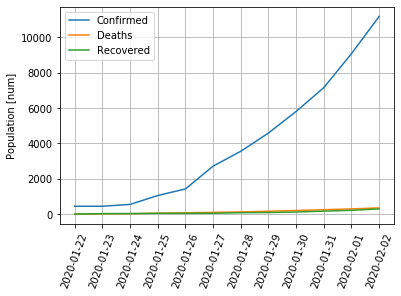

In [366]:
plt.plot(df_Hubei.Date,df_Hubei.Confirmed,label = 'Confirmed')
plt.plot(df_Hubei.Date,df_Hubei.Deaths,label = 'Deaths')
plt.plot(df_Hubei.Date,df_Hubei.Recovered,label = 'Recovered')
plt.legend()
plt.grid()
plt.xticks(df_Hubei.Date,rotation=70)
plt.ylabel('Population [num]')
plt.savefig('sample_img/Hubei_time_dose.png')

## SIRモデルの設計

死亡者も回復したヒトも，免疫を獲得していると考えることができるため，

Rt = df_Hubei.Deaths + df_Hubei.Recovered


In [367]:
days = df_Hubei.Days.values
I_days = df_Hubei.Confirmed.values
R_days = df_Hubei.Deaths.values + df_Hubei.Recovered.values
S_days = N - (It + Rt)

# SIR モデルによる時系列データの生成

初期のデータは信憑性が低いため，直近の値をもとに，微分方程式を逆向きに解く


In [368]:
beta = 1e-8
gamma = 1e-2
h = 0.01
times = np.arange(0,days[-1]+h,h)


St = np.zeros(times.shape)
It = np.zeros(times.shape)
Rt = np.zeros(times.shape)
St[-1] = S_days[-1]
It[-1] = I_days[-1]
Rt[-1] = R_days[-1]


for i in range(times.shape[0]-1):
    St[-i-2] = St[-i-1] +  h*(beta * St[-i-1] * It[-i-1])
    It[-i-2] = It[-i-1] +  h*(-beta * St[-i-1] * It[-i-1] + gamma * It[-i-1])
    Rt[-i-2] = Rt[-i-1] +  h*(-gamma * It[-i-1])
#     非不のシステムなので
    if St[-i-2]<0:
        St[-i-2] = 0
    if It[-i-2]<0:
        It[-i-2] = 0
    if Rt[-i-2]<0:
        Rt[-i-2] = 0



    

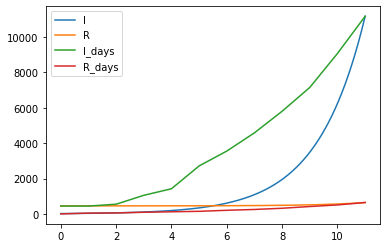

In [369]:
# とりあえずプロット
plt.plot(times,It,label='I')
plt.plot(times,Rt,label='R')
plt.plot(days,I_days,label='I_days')
plt.plot(days,R_days,label='R_days')
plt.legend()

## パラメータフィッティング

とっても適当な更新則

In [370]:
N_opt = 100
gammas= np.zeros(N_opt)
betas= np.zeros(N_opt)
gammas[0] = gamma
betas[0] = beta


St = np.zeros(times.shape)
It = np.zeros(times.shape)
Rt = np.zeros(times.shape)
St[-1] = S_days[-1]
It[-1] = I_days[-1]
Rt[-1] = R_days[-1]

for i_opt in range(N_opt-1):
    #SIRモデルによる微分方程式の解（逆向き）    
    for i in range(times.shape[0]-1):
        St[-i-2] = St[-i-1] +  h*(betas[i_opt] * St[-i-1] * It[-i-1])
        It[-i-2] = It[-i-1] +  h*(-betas[i_opt] * St[-i-1] * It[-i-1] + gammas[i_opt] * It[-i-1])
        Rt[-i-2] = Rt[-i-1] +  h*(-gammas[i_opt] * It[-i-1])
    #     非不のシステムなので
        if St[-i-2]<0:
            St[-i-2] = 0
        if It[-i-2]<0:
            It[-i-2] = 0
        if Rt[-i-2]<0:
            Rt[-i-2] = 0
# 適当更新則
    gammas[i_opt+1] = gammas[i_opt] - 1e-5 * np.mean(R_days - Rt[::int(1/h)])
    betas[i_opt+1] = betas[i_opt] - 1e-14 * np.mean(I_days - It[::int(1/h)])
    
    if gammas[i_opt+1]<0:
        gammas[i_opt+1] = 0
    if betas[i_opt+1]<0:
        betas[i_opt+1] = 0




    

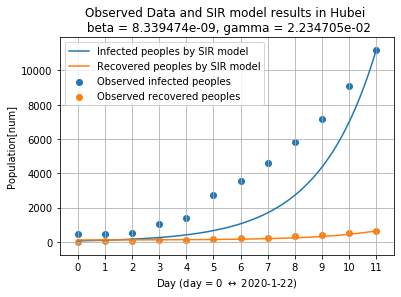

In [371]:
plt.plot(times,It,label='Infected peoples by SIR model')
plt.plot(times,Rt,label='Recovered peoples by SIR model')
plt.scatter(days,I_days,label='Observed infected peoples')
plt.scatter(days,R_days,label='Observed recovered peoples')
plt.ylabel('Population[num]')
plt.legend()
plt.grid()
plt.xticks(days)
plt.xlabel('Day (day = 0 $\leftrightarrow$ 2020-1-22)')

plt.title('Observed Data and SIR model results in Hubei \n beta = {0:e}, gamma = {1:e}'.format(betas[-2],gammas[-2]))
plt.savefig('sample_img/SIR_model_Hubei.png')

# 将来予測

In [372]:

times_f = np.arange(days[-1],365+h,h)


beta = betas[-2] 
gamma = gammas[-2]


Sf = np.zeros(times_f.shape)
If = np.zeros(times_f.shape)
Rf = np.zeros(times_f.shape)
Sf[0] = S_days[-1]
If[0] = I_days[-1]
Rf[0] = R_days[-1]


for i in range(times_f.shape[0]-1):
    Sf[i+1] = Sf[i] +  h*(-beta * Sf[i] * If[i])
    If[i+1] = If[i] +  h*(beta * Sf[i] * If[i] - gamma * If[i])
    Rf[i+1] = Rf[i] +  h*(gamma * If[i])
#     非不のシステムなので
    if Sf[i+1]<0:
        Sf[i+1] = 0
    if If[i+1]<0:
        If[i+1] = 0
    if Rf[i+1]<0:
        Rf[i+1] = 0



    

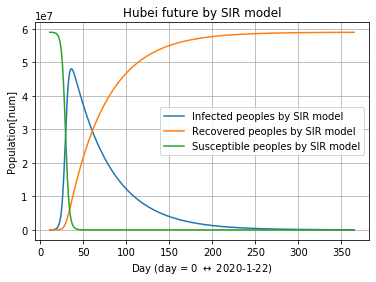

In [373]:
# plt.plot(times,It,label='Infected peoples by SIR model',color = 'red')

plt.plot(times_f,If,label='Infected peoples by SIR model')
plt.plot(times_f,Rf,label='Recovered peoples by SIR model')
plt.plot(times_f,Sf,label='Susceptible peoples by SIR model')



plt.ylabel('Population[num]')
plt.title('Hubei future by SIR model')
plt.xlabel('Day (day = 0 $\leftrightarrow$ 2020-1-22)')

plt.grid()
plt.legend()

plt.savefig('sample_img/Hubei_future.png')